# 1.Import

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

from tensorboard.backend.event_processing import event_accumulator
import copy
import glob
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import pandas as pd

# 2.Create datasets

In [2]:
train_files = glob.glob('data/*/train/*.tfrec')
val_files = glob.glob('data/*/val/*.tfrec')
test_files = glob.glob('data/tfrecords-jpeg-331x331/test/*.tfrec')

In [3]:
class Dataset(Dataset):
    def __init__(self, filenames, transform=None, is_labeled=True):
        self.filenames = filenames
        self.transform = transform
        self.is_labeled = is_labeled
        self.records = self.parse_files()
    
    def parse_files(self):
        train_feature_description = {
            'class': tf.io.FixedLenFeature([], tf.int64),
            'id': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string)
        }
        test_feature_description = {
            'id': tf.io.FixedLenFeature([], tf.string),
            'image': tf.io.FixedLenFeature([], tf.string)
        }
        records = []
        for filename in self.filenames:
            file = tf.data.TFRecordDataset(filename)
            if self.is_labeled:
                file = list(file.map(lambda x: tf.io.parse_single_example(x, train_feature_description)))
            else:
                file = list(file.map(lambda x: tf.io.parse_single_example(x, test_feature_description)))
            records += file
        return records
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, index):
        record = self.records[index]
        if self.transform:
            x = self.transform(Image.open(io.BytesIO(record['image'].numpy())))
        else:
            x = Image.open(io.BytesIO(record['image'].numpy()))
        if self.is_labeled:
            return x, record['class'].numpy()
        else:
            return x, record['id'].numpy().decode('utf-8')

In [4]:
def add_noise(x):
    noise = torch.randn_like(x)*0.1
    return x + noise

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(add_noise),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = Dataset(train_files, train_transform)
val_dataset = Dataset(val_files, test_transform)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=66, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=66, shuffle=True)
print(f'Train dataset has {len(train_dataloader.dataset)} images')
print(f'Validation dataset has {len(val_dataloader.dataset)} images')

Train dataset has 51012 images
Validation dataset has 14848 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


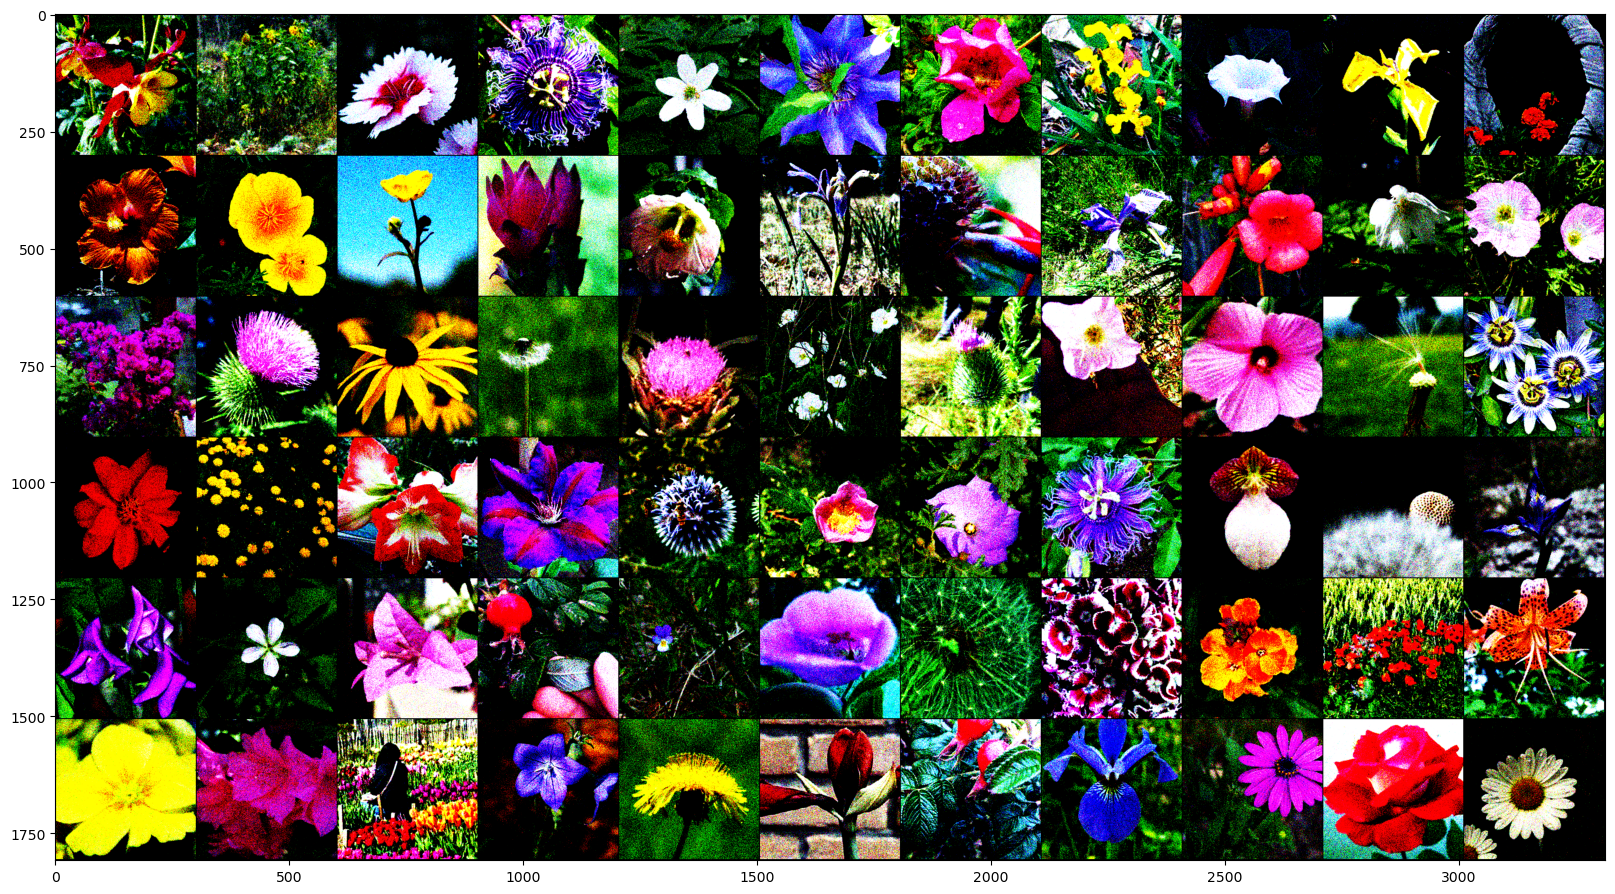

In [7]:
train_dataloader_iter = iter(train_dataloader)
x, y = next(train_dataloader_iter)

plt.figure(figsize=(20,30))
plt.imshow(np.transpose(torchvision.utils.make_grid(x, nrow=11), (1, 2, 0)));

# 3.Create Model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
class EarlyStopper:
    def __init__(self, model, patience, threshold, is_abs=False):
        self.patience = patience
        self.threshold = threshold
        self.counter = 0
        self.best_loss = 1
        self.model = model
        self.state_dict = copy.deepcopy(model.state_dict())
        self.stopped = False
        self.is_abs=is_abs

    def check(self, loss):
        if not self.stopped:
            if not self.is_abs:
                difference = self.best_loss * (1 - self.threshold)
            else:
                difference = self.best_loss - self.threshold

            if loss < difference:
                self.best_loss = loss
                self.state_dict = copy.deepcopy(self.model.state_dict())
                self.counter = 0
            else:
                if self.counter < self.patience-1:
                    self.counter += 1
                else:
                    self.stopped = True
        return self.stopped
    
    def get_state_dict(self):
        return self.state_dict
    
    def zero_counter(self):
        self.counter = 0
        self.stopped = False
        self.best_loss = 1

In [10]:
class Model(torch.nn.Module):
    def __init__(self, n_out):
        super().__init__()
        state_dict = torch.hub.load_state_dict_from_url(
            'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
            model_dir='.',
            check_hash=True
        )
        self.model = models.inception_v3()
        self.model.load_state_dict(state_dict)
        self.n_out = n_out
        self.model.fc = torch.nn.Linear(2048, n_out)
        self.freeze()

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        for name, param in self.model.named_parameters():
            if not name.startswith("fc"):
                param.requires_grad = False

    def unfreeze(self, start_index, end_index):
        for idx, layer in enumerate(self.model.children()):
            if start_index <= idx <= end_index:
                for param in layer.parameters():
                    param.requires_grad = True
    
    def train_step(self, train_dataloader, optimizer, criterion):
        train_loss = 0
        train_correct = 0

        for x, y in train_dataloader:
            optimizer.zero_grad()
            x_train, y_train = x.to(device).float(), torch.nn.functional.one_hot(y, self.n_out).to(device).float()
            output = self(x_train).logits
            loss = criterion(output, y_train)
            train_loss += loss.item()
            train_correct += (y.to(device).float() == torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)).float().sum()
            loss.backward()
            optimizer.step()
        train_loss = train_loss/len(train_dataloader.dataset)
        train_correct = train_correct/len(train_dataloader.dataset)
        return train_loss, train_correct
    
    def val_step(self, val_dataloader, criterion):
        val_loss = 0
        val_correct = 0
        self.eval()
        with torch.no_grad():
            for x, y in val_dataloader:
                x_val, y_val = x.to(device).float(), torch.nn.functional.one_hot(y, self.n_out).to(device).float()
                pred = self(x_val)
                val_loss += criterion(pred, y_val).item()
                val_correct += (y.to(device).float() == torch.argmax(torch.nn.functional.softmax(pred, dim=1), dim=1)).float().sum()
        self.train()
        val_loss = val_loss/len(val_dataloader.dataset)
        val_correct = val_correct/len(val_dataloader.dataset)
        return val_loss, val_correct
    
    def fit(self, n_epochs, train_dataloader, val_dataloader, optimizer, criterion, start_epoch=0, writer=None, scheduler=None, early_stopper=None):
        pb_length = 50
        lr = optimizer.param_groups[0]["lr"]
        for epoch in range(start_epoch, start_epoch + n_epochs):
            train_loss, train_acc = self.train_step(train_dataloader, optimizer, criterion)
            val_loss, val_acc = self.val_step(val_dataloader, criterion)
            if early_stopper:
                if early_stopper.check(val_loss):
                    self.load_state_dict(early_stopper.get_state_dict())
                    break
            if writer:
                writer.add_scalar('Train/loss', train_loss, epoch)
                writer.add_scalar('Train/accuracy', train_acc, epoch)
                writer.add_scalar('Validation/loss', val_loss, epoch)
                writer.add_scalar('Validation/accuracy', val_acc, epoch)
            if scheduler:
                scheduler.step(val_loss)
                lr = optimizer.param_groups[0]["lr"]
                if writer:
                    writer.add_scalar('Learning rate', lr, epoch)
            pb_progress = epoch - start_epoch+ 1
            pb_percent = pb_length * (pb_progress / n_epochs)
            pb_bar = "❚" * int(pb_percent) + " " * (pb_length - int(pb_percent))
            print(f"|{pb_bar}| {pb_progress} / {n_epochs}, train_loss = {train_loss:.4f}, train_accuracy = {train_acc:.4f}, val_loss = {val_loss:.4f}, val_accuracy = {val_acc:.4f}, lr = {lr:.3}", end="\r")
        early_stopper.zero_counter()

In [11]:
model = Model(104).to(device)

/home/vlad/.conda/envs/default/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


# 4.Train

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.3, 3, threshold=0.01)
early_stopper = EarlyStopper(model, patience=8, threshold=0.01)
writer = SummaryWriter()

In [13]:
model.fit(50, train_dataloader, val_dataloader, optimizer, criterion, writer=writer, scheduler=scheduler, early_stopper=early_stopper)

In [15]:
# torch.save(model.state_dict(), 'model_freeze.pth')

In [12]:
model.load_state_dict(torch.load('model_freeze.pth'))

<All keys matched successfully>

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=36, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=36, shuffle=True)

In [15]:
model.unfreeze(0, 21)

In [16]:
model.fit(20, train_dataloader, val_dataloader, optimizer, criterion, writer=writer, scheduler=scheduler, early_stopper=early_stopper, start_epoch=29)

In [17]:
# torch.save(model.state_dict(), 'model_weights.pth')

In [14]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

# 5.Visualize results

In [2]:
def get_scalar(path):
  event_acc = event_accumulator.EventAccumulator(path)
  event_acc.Reload()
  data = {}

  for tag in sorted(event_acc.Tags()["scalars"]):
    x, y = [], []

    for scalar_event in event_acc.Scalars(tag):
      x.append(scalar_event.step)
      y.append(scalar_event.value)

    data[tag] = (np.asarray(x), np.asarray(y))
  return data

In [3]:
freezed_plot = get_scalar('runs/Jun26_12-27-22_Vlad-Legion')
unfreezed_plot = get_scalar('runs/Jun26_16-15-51_Vlad-Legion')

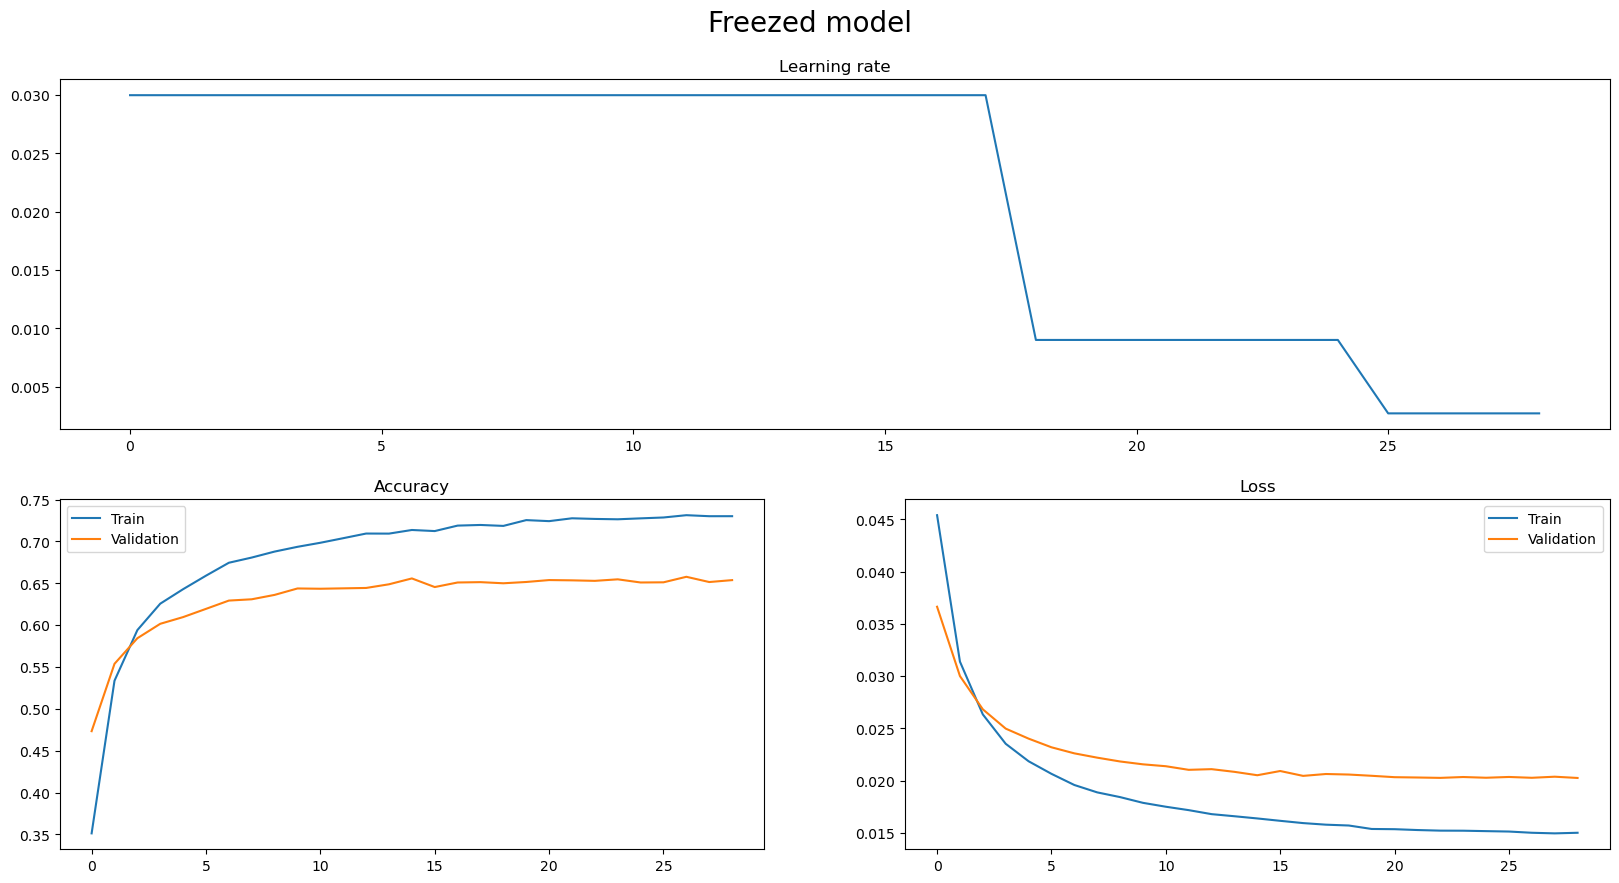

In [4]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Freezed model', fontsize=20, y=0.95)
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.set_title('Learning rate')
ax1.plot(freezed_plot['Learning rate'][0], freezed_plot['Learning rate'][1])
ax2.set_title('Accuracy')
ax2.plot(freezed_plot['Train/accuracy'][0], freezed_plot['Train/accuracy'][1], label="Train")
ax2.plot(freezed_plot['Validation/accuracy'][0], freezed_plot['Validation/accuracy'][1], label="Validation")
ax3.set_title('Loss')
ax3.plot(freezed_plot['Train/loss'][0], freezed_plot['Train/loss'][1], label="Train")
ax3.plot(freezed_plot['Validation/loss'][0], freezed_plot['Validation/loss'][1], label="Validation")
ax2.legend()
ax3.legend()
plt.show()

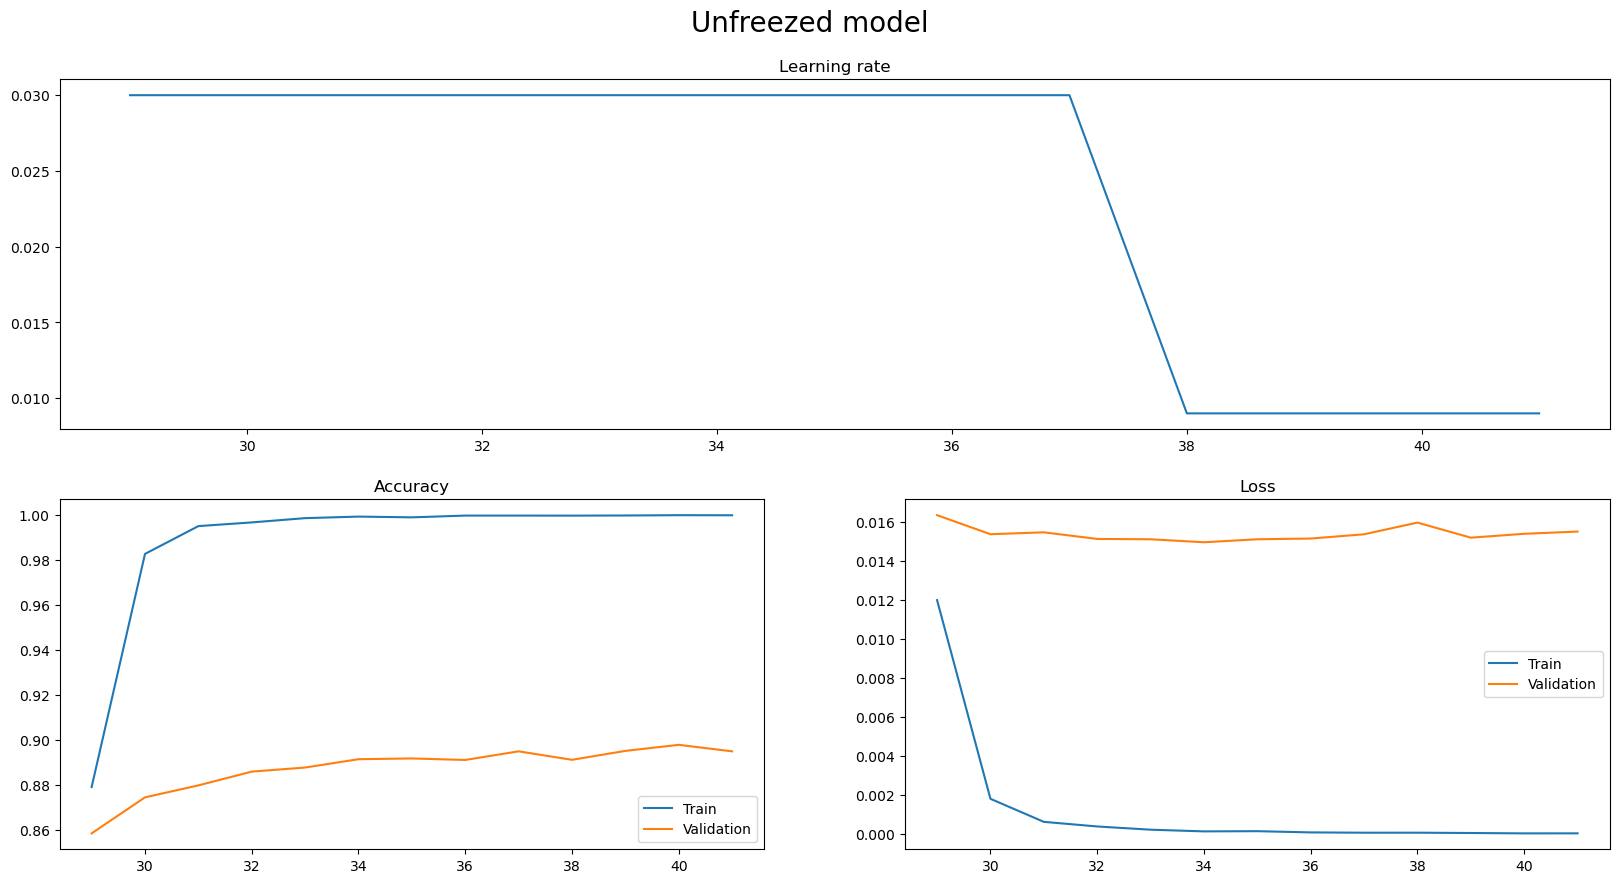

In [5]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Unfreezed model', fontsize=20, y=0.95)
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.set_title('Learning rate')
ax1.plot(unfreezed_plot['Learning rate'][0], unfreezed_plot['Learning rate'][1])
ax2.set_title('Accuracy')
ax2.plot(unfreezed_plot['Train/accuracy'][0], unfreezed_plot['Train/accuracy'][1], label="Train")
ax2.plot(unfreezed_plot['Validation/accuracy'][0], unfreezed_plot['Validation/accuracy'][1], label="Validation")
ax3.set_title('Loss')
ax3.plot(unfreezed_plot['Train/loss'][0], unfreezed_plot['Train/loss'][1], label="Train")
ax3.plot(unfreezed_plot['Validation/loss'][0], unfreezed_plot['Validation/loss'][1], label="Validation")
ax2.legend()
ax3.legend()
plt.show()

# 6.Create submission

In [15]:
test_dataset = Dataset(test_files, test_transform, False)
test_dataloader = DataLoader(test_dataset, batch_size=128)
print(f'Test dataset has {len(test_dataloader.dataset)} images')

Test dataset has 7382 images


In [16]:
df = pd.DataFrame(columns=['id', 'label'])
model.eval()
for image, id in test_dataloader:
    output = model(image.to(device))
    pred = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
    df = pd.concat([df, pd.DataFrame(zip(id, [t.item() for t in pred.cpu()]), columns=df.columns)], ignore_index=True)
df

,id,label
0,a98328317,14
1,e0098a158,103
2,0ae82a090,86
3,73a3ae7ee,47
4,410639882,82
...,...,...
7377,b0f5721ca,68
7378,754eab3b5,73
7379,5fab0c048,40
7380,9e99e1332,100


In [15]:
df.to_csv('submission.csv', index=False)